# Tâche 1 — Reconnaissance faciale robuste (Notebook unique)

Pipeline : lecture → détection/alignement → embeddings (modèle pré-entraîné) → **matching 1-à-1** → **export CSV**.


* Extraction d’embeddings avec un modèle pré-entraîné (InsightFace).  
   - Ici, tu ne réentraînes pas le modèle (il est déjà appris sur un énorme dataset, style MS-Celeb, Glint360k, etc.).
   - Tu l’utilises comme un extracteur de caractéristiques → image → vecteur 512D.

* Création de paires positives/négatives artificielles sur ton split dev.
  * Positives : deux images d’un même ID (ex. 0001_0 et 0001_1).
  * Négatives : deux images de IDs différents (ex. 0001_0 vs 0002_0).
  * C’est toi qui choisis comment générer les négatifs (voisin, aléatoire, multiple…).

* Évaluation uniquement par comparaison d’embeddings.
  * Produit scalaire (= cosinus car embeddings normalisés).
  * Tu traces ROC, calcules AUC/EER, simules un matching avec l’algorithme Hongrois.

## 1) Installation (si nécessaire)
Décommente la cellule ci-dessous si les dépendances ne sont pas installées.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %pip install --upgrade pip
# %pip install insightface opencv-python numpy scipy scikit-learn networkx tqdm matplotlib pyyaml

In [3]:
# pip install matplotlib
# 

## 2) Imports & configuration
Charge le YAML de config, prépare les dossiers, fixe la seed.

In [4]:
import os, glob, csv, json
from pathlib import Path
import numpy as np
import cv2
import yaml
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, roc_curve
from scipy.optimize import linear_sum_assignment

# Chargement de la config
CONFIG_PATH = Path("configs/config.yaml")
assert CONFIG_PATH.exists(), "Fichier configs/config.yaml introuvable."
config = yaml.safe_load(open(CONFIG_PATH, "r", encoding="utf-8"))

DATA_DIR   = Path(config["paths"]["data_dir"])
TRAIN_DIR  = Path(config["paths"]["train_dir"])
TEST_DIR   = Path(config["paths"]["test_dir"])
OUT_DIR    = Path(config["paths"]["outputs_dir"])
FIG_DIR    = Path(config["paths"]["figures_dir"])

MODEL_NAME = config["model"]["insightface_name"]
CTX_ID     = int(config["model"]["ctx_id"])
DET_SIZE   = tuple(config["model"]["det_size"])

DEV_RATIO  = float(config["dev_eval"]["dev_ratio"])
SEED       = int(config["dev_eval"]["random_seed"])

EXPORT_NAME = config["matching"]["export_filename"]
SAVE_FIG    = bool(config["logging"]["save_figures"])

np.random.seed(SEED)
OUT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print("Config:", json.dumps(config, indent=2))

Config: {
  "paths": {
    "data_dir": "data",
    "train_dir": "data/train",
    "test_dir": "data/test",
    "outputs_dir": "outputs",
    "figures_dir": "outputs/figures"
  },
  "model": {
    "insightface_name": "buffalo_l",
    "ctx_id": 0,
    "det_size": [
      640,
      640
    ]
  },
  "dev_eval": {
    "dev_ratio": 0.2,
    "random_seed": 42
  },
  "matching": {
    "solver": "hungarian",
    "block_size": 0,
    "export_filename": "tache1_submission.csv"
  },
  "logging": {
    "verbose": true,
    "save_figures": true
  }
}


## 3) Détecteur + extracteur d'embeddings (InsightFace)
Utilise un backbone ArcFace pré-entraîné (`buffalo_l`). Retourne des embeddings **L2-normalisés** (512D).

In [5]:
# %pip install numpy scipy scikit-learn matplotlib tqdm pyyaml
# %pip install opencv-python-headless
# %pip install "insightface>=0.7.3" onnxruntime-gpu

In [6]:
# METHODE D'EMBEDDING 1
from insightface.app import FaceAnalysis

ROOT = "C:\Python312\Lib\site-packages\insightface"

app = FaceAnalysis(
    name=MODEL_NAME,
    root=ROOT,
    allowed_modules=['detection', 'recognition']
)
app.prepare(ctx_id=CTX_ID, det_size=DET_SIZE)

def embed_one_image(path: str):
    """
    Retourne l'embedding L2-normalisé (np.ndarray (512,)) ou None si aucun visage valide.
    """
    img = cv2.imread(path)
    if img is None:
        return None
    img_rgb = img[:, :, ::-1]  # BGR -> RGB
    faces = app.get(img_rgb)
    if not faces:
        return None
    f = max(faces, key=lambda x: x.det_score)
    return f.normed_embedding  # float32, déjà L2-normalisé


<>:4: SyntaxWarning: invalid escape sequence '\P'
<>:4: SyntaxWarning: invalid escape sequence '\P'
C:\Users\kokou\AppData\Local\Temp\ipykernel_13604\3516103323.py:4: SyntaxWarning: invalid escape sequence '\P'
  ROOT = "C:\Python312\Lib\site-packages\insightface"


Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CUDAExecutionProvider': {'device_id': '0', 'has_user_compute_stream': '0', 'cudnn_conv1d_pad_to_nc1d': '0', 'user_compute_stream': '0', 'gpu_external_alloc': '0', 'gpu_mem_limit': '18446744073709551615', 'enable_cuda_graph': '0', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'do_copy_in_default_stream': '1', 'cudnn_conv_use_max_workspace': '1', 'tunable_op_enable': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'prefer_nhwc': '0', 'use_ep_level_unified_stream': '0', 'use_tf32': '1', 'sdpa_kernel': '0', 'fuse_conv_bias': '0'}, 'CPUExecutionProvider': {}}
model ignore: C:\Python312\Lib\site-packages\insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with optio

In [7]:
# METHODE D'EMBEDDING 2
# --- Paramètres d'extraction robustes ---
MIN_DET_SCORE = 1   # rejeter les détections trop faibles
MIN_FACE_SIZE = 30     # en pixels (côté court de la bbox); augmente si images HD
FACE_SELECT   = "score"  # "score" (confiance max) ou "area" (plus grand visage)
USE_TTA_FLIP  = False   # True = moyenne embedding(image) + embedding(image miroir)

import numpy as np
import cv2
from typing import Optional
from insightface.app import FaceAnalysis

def _bbox_area(f):
    x1, y1, x2, y2 = f.bbox.astype(int)
    return max(0, x2 - x1) * max(0, y2 - y1)

def _face_is_valid(f):
    x1, y1, x2, y2 = f.bbox.astype(int)
    w, h = x2 - x1, y2 - y1
    return (f.det_score is not None and f.det_score >= MIN_DET_SCORE and min(w, h) >= MIN_FACE_SIZE)

def _select_face(faces):
    # Filtre qualité
    candidates = [f for f in faces if _face_is_valid(f)]
    if not candidates:
        return None
    if FACE_SELECT == "area":
        return max(candidates, key=_bbox_area)
    # défaut: meilleur score de détection
    return max(candidates, key=lambda f: f.det_score)

def embed_one_image_robust(path: str) -> Optional[np.ndarray]:
    """
    Extraction robuste:
      - filtre des visages (score/tailles minimales)
      - sélection du meilleur visage (score ou surface)
      - TTA flip optionnel (moyenne embedding original + miroir)
    Renvoie un embedding L2-normalisé (float32, shape (512,)) ou None.
    """
    img_bgr = cv2.imread(path)
    if img_bgr is None:
        return None
    img_rgb = img_bgr[:, :, ::-1]

    # 1) visage sur image originale
    faces = app.get(img_rgb)
    f = _select_face(faces) if faces else None
    if f is None:
        return None
    emb = f.normed_embedding.astype(np.float32)

    if not USE_TTA_FLIP:
        return emb

    # 2) visage sur image miroir (TTA flip)
    img_rgb_flip = img_rgb[:, ::-1, :]
    faces_f = app.get(img_rgb_flip)
    f2 = _select_face(faces_f) if faces_f else None

    if f2 is None:
        return emb  # pas de visage fiable sur le flip → on garde l’original

    emb2 = f2.normed_embedding.astype(np.float32)

    # 3) fusion (moyenne + re-normalisation L2)
    emb_sum = emb + emb2
    nrm = np.linalg.norm(emb_sum)
    if nrm == 0:
        return emb  # fallback très rare
    return (emb_sum / nrm).astype(np.float32)


In [8]:
EMBED_FUNCTION_TO_USE = [
    embed_one_image,
    embed_one_image_robust
][0]

In [9]:
from pathlib import Path

# Lister tous les fichiers du dossier train
all_images = list(Path(TRAIN_DIR).glob("*.jpg"))

print("Nb d'images dans train:", len(all_images))
print("Exemple:", all_images[:3])

# Prendre la première image
img_path = all_images[0]

# Extraire l'embedding
embedding = EMBED_FUNCTION_TO_USE(str(img_path))
print("Taille embedding:", embedding.shape)
print("Aperçu:", embedding[:5])


Nb d'images dans train: 4000
Exemple: [WindowsPath('data/train/0000_0.jpg'), WindowsPath('data/train/0000_1.jpg'), WindowsPath('data/train/0001_0.jpg')]
Taille embedding: (512,)
Aperçu: [ 0.05048631  0.01550694 -0.02292652  0.05877784 -0.00682114]


## 4) Utilitaires : lecture train, split dev, extraction embeddings
- `read_train_pairs` lit les paires `XXXX_0`, `XXXX_1`.
- `split_train_dev` fait un split par identités.
- `embed_paths` calcule les embeddings d’une liste de chemins.


In [10]:
def read_train_pairs(train_dir: Path):
    """
    Retourne une liste [(id_str, path0, path1), ...] pour les identités ayant exactement 2 images.
    """
    exts = (".jpg", ".jpeg", ".png", ".bmp", ".webp")
    files = sorted([str(p) for p in train_dir.iterdir() if p.suffix.lower() in exts])
    by_id = {}
    for p in files:
        name = Path(p).stem  # e.g., 0123_0
        if "_" not in name:
            continue
        pid = name.rsplit("_", 1)[0]
        by_id.setdefault(pid, []).append(p)
    pairs = []
    for pid, paths in by_id.items():
        if len(paths) == 2:
            p0, p1 = sorted(paths)
            pairs.append((pid, p0, p1))
    return pairs

def split_train_dev(pairs, dev_ratio=0.2, seed=42):
    n = len(pairs)
    idx = np.arange(n)
    rng = np.random.default_rng(seed)
    rng.shuffle(idx)
    cut = int(n * (1 - dev_ratio))
    return [pairs[i] for i in idx[:cut]], [pairs[i] for i in idx[cut:]]

def embed_paths(paths):
    """
    Calcule les embeddings pour une liste de chemins d'images.
    Retourne (embeddings_list, same_length_paths_list).
    """
    E, P = [], []
    for p in tqdm(paths, desc="Embeddings"):
        e = EMBED_FUNCTION_TO_USE(p)
        E.append(None if e is None else e.astype(np.float32))
        P.append(p)
    return E, P


## 5) Évaluation sur split dev : ROC/EER + matching simulé
Permet de **valider** que la baseline se comporte bien avant de lancer le test.


In [11]:
def pair_scores_dev(dev_images, dev_labels, dev_embeddings):
    """
    Construit des paires positives (même ID) et négatives (décalage simple),
    renvoie y_true (1/0) et y_score (similarités).
    """
    pos_scores, neg_scores = [], []
    # positives: (2i, 2i+1)
    for i in range(0, len(dev_images), 2):
        e1, e2 = dev_embeddings[i], dev_embeddings[i+1]
        if e1 is None or e2 is None:
            continue
        pos_scores.append(float(np.dot(e1, e2)))
    # négatives: croiser avec l'identité suivante
    for i in range(0, len(dev_images), 2):
        j = (i + 2) % len(dev_images)
        e1, e2 = dev_embeddings[i], dev_embeddings[j]
        if e1 is None or e2 is None:
            continue
        neg_scores.append(float(np.dot(e1, e2)))
    y_true = np.array([1]*len(pos_scores) + [0]*len(neg_scores))
    y_score = np.array(pos_scores + neg_scores)
    return y_true, y_score

In [12]:
import numpy as np
rng = np.random.default_rng(SEED)  # SEED défini dans ton config.yaml

def pair_scores_dev_multi(dev_images, dev_labels, dev_embeddings, k_neg=5):
    """
    Construit des paires positives (même ID) et plusieurs paires négatives (k_neg par ID).
    Retourne y_true (1=positif, 0=négatif) et y_score (similarités cosinus).
    """
    idx_by_id = {}
    for idx, pid in enumerate(dev_labels):
        if dev_embeddings[idx] is None:
            continue
        idx_by_id.setdefault(pid, []).append(idx)

    pos_scores = []
    neg_scores = []

    # Paires positives
    for pid, idxs in idx_by_id.items():
        if len(idxs) >= 2:
            e1, e2 = dev_embeddings[idxs[0]], dev_embeddings[idxs[1]]
            if e1 is not None and e2 is not None:
                pos_scores.append(float(np.dot(e1, e2)))

    # Paires négatives (k_neg par ID)
    unique_ids = list(idx_by_id.keys())
    for pid in unique_ids:
        anchor_idx = idx_by_id[pid][0]  # première image de cet ID
        e_anchor = dev_embeddings[anchor_idx]
        if e_anchor is None:
            continue
        # tirer k_neg autres IDs
        other_ids = [p for p in unique_ids if p != pid]
        chosen = rng.choice(other_ids, size=min(k_neg, len(other_ids)), replace=False)
        for pid_neg in chosen:
            neg_idx = idx_by_id[pid_neg][0]  # première image de l'autre ID
            e_neg = dev_embeddings[neg_idx]
            if e_neg is not None:
                neg_scores.append(float(np.dot(e_anchor, e_neg)))

    y_true = np.array([1]*len(pos_scores) + [0]*len(neg_scores))
    y_score = np.array(pos_scores + neg_scores)
    return y_true, y_score


In [13]:
PAIR_SCORE_DEV_TO_USE = [
    pair_scores_dev,
    pair_scores_dev_multi
][0]

#IDs dans train : 2000
Split => train: 1600 | dev: 400


Embeddings: 100%|██████████| 800/800 [00:34<00:00, 23.08it/s]


AUC = 0.7592 | EER ≈ 0.3501 @ thr = 0.0381


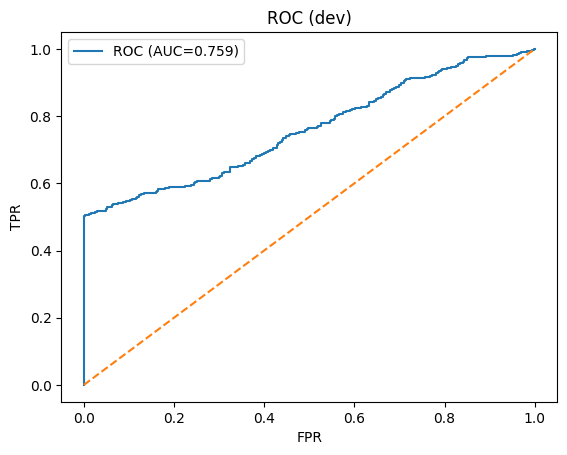

Matching simulé (dev) : 382 paires, accuracy = 0.3586


In [14]:
def compute_eer(fpr, tpr, thresholds):
    fnr = 1 - tpr
    idx = np.nanargmin(np.abs(fnr - fpr))
    eer = (fnr[idx] + fpr[idx]) / 2
    return eer, thresholds[idx]

def simulate_matching(dev_embeddings, dev_labels):
    """
    Matching parfait simulé sur le split dev, renvoie (accuracy, nb_paires, liste_indices_paires).
    """
    valid_idx = [i for i, e in enumerate(dev_embeddings) if e is not None]
    if len(valid_idx) < 2:
        return 0.0, 0, []

    E = np.stack([dev_embeddings[i] for i in valid_idx], axis=0)
    S = E @ E.T
    np.fill_diagonal(S, -np.inf)
    cost = -S

    row, col = linear_sum_assignment(cost)
    used = set()
    pairs = []
    for r, c in zip(row, col):
        if r != c and r not in used and c not in used:
            pairs.append((r, c, float(S[r, c])))
            used.add(r); used.add(c)

    # accuracy: même ID ?
    idmap = {k: dev_labels[valid_idx[k]] for k in range(len(valid_idx))}
    correct = sum(1 for r, c, _ in pairs if idmap[r] == idmap[c])
    acc = correct / len(pairs) if pairs else 0.0
    return acc, len(pairs), [(valid_idx[r], valid_idx[c], s) for r, c, s in pairs]

# --- pipeline dev ---
pairs = read_train_pairs(TRAIN_DIR)
print(f"#IDs dans train : {len(pairs)}")
train_pairs, dev_pairs = split_train_dev(pairs, dev_ratio=DEV_RATIO, seed=SEED)
print(f"Split => train: {len(train_pairs)} | dev: {len(dev_pairs)}")

# construire le lot dev (images/labels)
dev_images, dev_labels = [], []
for pid, p0, p1 in dev_pairs:
    dev_images.extend([p0, p1])
    dev_labels.extend([pid, pid])

# embeddings dev
dev_embeddings, _ = embed_paths(dev_images)

# ROC/EER
if len(dev_images) >= 2:
    y_true, y_score = PAIR_SCORE_DEV_TO_USE(dev_images, dev_labels, dev_embeddings)
    if len(np.unique(y_true)) == 2 and len(y_true) > 0:
        auc = roc_auc_score(y_true, y_score)
        fpr, tpr, thr = roc_curve(y_true, y_score)
        eer, thr_eer = compute_eer(fpr, tpr, thr)
        print(f"AUC = {auc:.4f} | EER ≈ {eer:.4f} @ thr = {thr_eer:.4f}")
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
        plt.plot([0, 1], [0, 1], "--")
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.title("ROC (dev)")
        if SAVE_FIG:
            Path(FIG_DIR).mkdir(parents=True, exist_ok=True)
            plt.savefig(Path(FIG_DIR) / "roc_dev.png", bbox_inches="tight", dpi=120)
        plt.show()
    else:
        print("Je ne peux pas tracer la ROC (pas assez de paires valides).")

# Matching simulé sur dev
acc, n_pairs, _pairs_idx = simulate_matching(dev_embeddings, dev_labels)
print(f"Matching simulé (dev) : {n_pairs} paires, accuracy = {acc:.4f}")


In [15]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Choix d’un seuil (ici celui trouvé à l’EER, mais tu peux en tester d’autres)
y_pred = (y_score >= thr_eer).astype(int)

# Calcul des métriques
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")
acc = accuracy_score(y_true, y_pred)

print("\n=== Évaluation binaire @ seuil EER ===")
print(f"Accuracy  : {acc:.4f}")
print(f"Précision : {precision:.4f}")
print(f"Rappel    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}")



=== Évaluation binaire @ seuil EER ===
Accuracy  : 0.6499
Précision : 0.6475
Rappel    : 0.6524
F1-score  : 0.6499


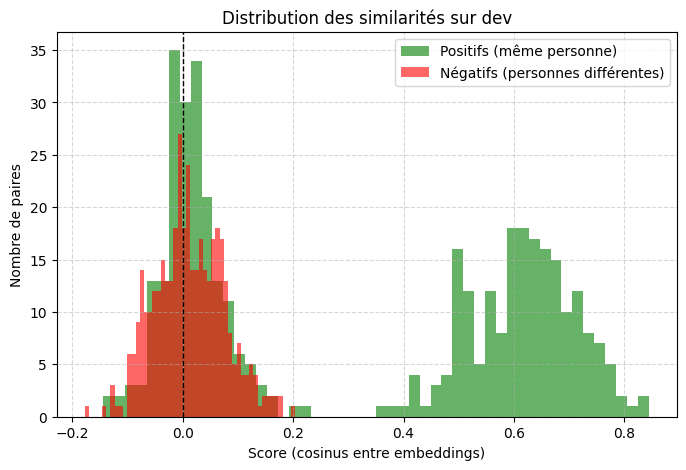

In [16]:
import matplotlib.pyplot as plt

def plot_score_histograms(y_true, y_score, bins=50):
    """
    Trace les histogrammes des scores pour paires positives et négatives.
    """
    pos_scores = y_score[y_true == 1]
    neg_scores = y_score[y_true == 0]

    plt.figure(figsize=(8,5))
    plt.hist(pos_scores, bins=bins, alpha=0.6, color="green", label="Positifs (même personne)")
    plt.hist(neg_scores, bins=bins, alpha=0.6, color="red", label="Négatifs (personnes différentes)")
    plt.axvline(0.0, color="black", linestyle="--", linewidth=1)
    plt.xlabel("Score (cosinus entre embeddings)")
    plt.ylabel("Nombre de paires")
    plt.title("Distribution des similarités sur dev")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

# --- Exemple d'utilisation après ton calcul ---
y_true, y_score = pair_scores_dev(dev_images, dev_labels, dev_embeddings)
plot_score_histograms(y_true, y_score)


In [17]:
from sklearn.metrics import precision_recall_fscore_support

def best_f1_threshold(y_true, y_score, num_thresholds=200):
    """
    Cherche le seuil qui maximise le F1-score.
    Explore num_thresholds valeurs entre min(y_score) et max(y_score).
    """
    thresholds = np.linspace(y_score.min(), y_score.max(), num_thresholds)
    best_thr, best_f1 = None, -1
    best_prec, best_rec = None, None

    for thr in thresholds:
        y_pred = (y_score >= thr).astype(int)
        prec, rec, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average="binary", zero_division=0
        )
        if f1 > best_f1:
            best_f1 = f1
            best_thr = thr
            best_prec, best_rec = prec, rec

    return best_thr, best_f1, best_prec, best_rec

# --- Exemple d’utilisation ---
y_true, y_score = pair_scores_dev(dev_images, dev_labels, dev_embeddings)

thr_f1, f1, prec, rec = best_f1_threshold(y_true, y_score)
print("\n=== Seuil optimisé pour F1 ===")
print(f"Seuil optimal : {thr_f1:.4f}")
print(f"Précision     : {prec:.4f}")
print(f"Rappel        : {rec:.4f}")
print(f"F1-score      : {f1:.4f}")



=== Seuil optimisé pour F1 ===
Seuil optimal : -0.0280
Précision     : 0.5559
Rappel        : 0.9144
F1-score      : 0.6914


## 6) Inférence sur **test** + matching 1-à-1 + export CSV
Produit `outputs/tache1_submission.csv` au format :

image_A,image_B,similarity

imgA.jpg,imgB.jpg,0.812534

In [18]:
# Lister les images test
exts = (".jpg", ".jpeg", ".png", ".bmp", ".webp")
test_paths = sorted([str(p) for p in Path(TEST_DIR).iterdir() if p.suffix.lower() in exts])
print("#images test :", len(test_paths))
assert len(test_paths) > 0, "Aucune image dans data/test."

# Embeddings test
test_embeddings, kept_paths = embed_paths(test_paths)

# Indices valides (visage détecté)
valid_idx = [i for i, e in enumerate(test_embeddings) if e is not None]
print("#images test valides (visage détecté) :", len(valid_idx))
if len(valid_idx) < 2:
    raise RuntimeError("Trop peu d'images test détectées. Augmente DET_SIZE ou mets ctx_id=-1 pour CPU.")

# Doit être pair pour appariement parfait
if len(valid_idx) % 2 == 1:
    print("⚠️ Nombre impair d'images valides : une image sera ignorée (score le plus faible au voisinage).")
    # on supprime l'indice avec la plus faible somme de similarité brute (approx)
    # calcule E provisoire
    E_tmp = np.stack([test_embeddings[i] for i in valid_idx], axis=0)
    S_tmp = E_tmp @ E_tmp.T
    np.fill_diagonal(S_tmp, 0.0)
    sums = S_tmp.sum(axis=1)
    drop_local = int(np.argmin(sums))
    drop_global = valid_idx[drop_local]
    valid_idx = [i for i in valid_idx if i != drop_global]

# Matrice de similarité
E = np.stack([test_embeddings[i] for i in valid_idx], axis=0)
S = E @ E.T
np.fill_diagonal(S, -np.inf)
cost = -S

# Hungarian
row, col = linear_sum_assignment(cost)
used = set()
pairs = []
for r, c in zip(row, col):
    if r != c and r not in used and c not in used:
        pairs.append((r, c, float(S[r, c])))
        used.add(r); used.add(c)

# Export CSV
export_path = Path(OUT_DIR) / EXPORT_NAME
export_path.parent.mkdir(parents=True, exist_ok=True)
with open(export_path, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["image_A", "image_B", "similarity"])
    for r, c, s in pairs:
        a = Path(kept_paths[valid_idx[r]]).name
        b = Path(kept_paths[valid_idx[c]]).name
        w.writerow([a, b, f"{s:.6f}"])

print("✅ CSV écrit :", export_path)


#images test : 2000


Embeddings: 100%|██████████| 2000/2000 [01:30<00:00, 22.09it/s]


#images test valides (visage détecté) : 1979
⚠️ Nombre impair d'images valides : une image sera ignorée (score le plus faible au voisinage).
✅ CSV écrit : outputs\tache1_submission.csv
